## Prepare Dataset

In [ ]:
## 1 min 21 s
!gdown 1iBpVko2sehPeOPhQXWaujOpKFQmNvd_m
!unrar x -y -idq /content/RailSem19.rar RailSem19
!rm /content/RailSem19.rar

Downloading...
From (original): https://drive.google.com/uc?id=1iBpVko2sehPeOPhQXWaujOpKFQmNvd_m
From (redirected): https://drive.google.com/uc?id=1iBpVko2sehPeOPhQXWaujOpKFQmNvd_m&confirm=t&uuid=2d32eb4b-0625-43c4-aa18-b2beb0e16fec
To: /content/RailSem19.rar
100% 5.41G/5.41G [01:32<00:00, 58.4MB/s]


In [ ]:
import numpy as np
import json
from random import shuffle
import cv2
import sys

from sklearn.model_selection import train_test_split
from PIL import Image

In [ ]:
import os
import shutil
from tqdm.auto import tqdm

In [ ]:
mask_files = os.listdir('RailSem19/rs19_masks')
json_files = os.listdir('RailSem19/rs19_jsons')
len(mask_files)

8500

In [ ]:
train_ratio = 0.9  # 90% training, 10% validation
train_masks, val_masks = train_test_split(mask_files,
                                          train_size=train_ratio,
                                          random_state=42)

print("Training Paths:", len(train_masks))
print("Validation Paths:", len(val_masks))

Training Paths: 7650
Validation Paths: 850


In [ ]:
def create_directory_structure(root, segmentation_classes):
    # Define the main directory structure
    dirs = [
        f"{root}/images/train",
        f"{root}/images/val",
        f"{root}/detection-object/labels/train",
        f"{root}/detection-object/labels/val"
    ]

    # Add segmentation classes to the structure
    for seg_class in segmentation_classes:
        dirs.append(f"{root}/{seg_class}/labels/train")
        dirs.append(f"{root}/{seg_class}/labels/val")

    # Create the directories
    for directory in dirs:
        os.makedirs(directory, exist_ok=True)

root = "dataset_root"
segmentation_classes = ["track", "rail", "pole"] # rename as 'seg-track-02' 'seg-rail-03' 'seg-pole-04'
# segmentation_classes = ["track", "rail", "vegetation", "pole", "construction"]
create_directory_structure(root, segmentation_classes)
print("Directories Created !!!")

Directories Created !!!


In [ ]:
def polygon2bbox(pnts_draw):
      min_x = np.min(pnts_draw[:, 0])
      min_y = np.min(pnts_draw[:, 1])
      max_x = np.max(pnts_draw[:, 0])
      max_y = np.max(pnts_draw[:, 1])
      return min_x, min_y, max_x, max_y

def json2bbox(inp_path_json):
    restricted_classes=['track-sign-front',
                        'person-group','person',
                        'car', 'truck','train-car',
                        'track-signal-front', 'track-signal-back']

    inp_json = json.load(open(inp_path_json, 'r'))
    _ = {k:[] for k in restricted_classes}
    for obj in inp_json["objects"]:
        if not obj['label'] in restricted_classes:
          continue

        if "boundingbox" in obj:
            _[obj["label"]].append(obj["boundingbox"])

        elif "polygon" in obj:
            pnts_draw = np.around(np.array(obj["polygon"])).astype(np.int32)
            min_x, min_y, max_x, max_y = polygon2bbox(pnts_draw)
            _[obj["label"]].append([min_x, min_y, max_x, max_y])
    return _


def box2yolo(x1, y1, x2, y2, image_width, image_height, class_id):
    # Compute the center of the bounding box
    x_center = (x1 + x2) / 2.0
    y_center = (y1 + y2) / 2.0

    # Compute the width and height of the bounding box
    width = x2 - x1
    height = y2 - y1

    # Normalize the coordinates
    x_center_norm = x_center / image_width
    y_center_norm = y_center / image_height
    width_norm = width / image_width
    height_norm = height / image_height

    # YOLO format: class_id, x_center_norm, y_center_norm, width_norm, height_norm
    yolo_format = f"{class_id} {x_center_norm} {y_center_norm} {width_norm} {height_norm}"
    return yolo_format


def segment2yolo(coords,image_width, image_height, class_id):
    yolo_format = []
    for coord in coords:
        cnt2yolo = ''.join([f"{x / image_width} {y / image_height} " for x, y in coord])
        cnt2yolo = f"{class_id} {cnt2yolo}"
        yolo_format.append(cnt2yolo)
    return yolo_format



classes_dict = {
    ('track-signal-front', 'track-signal-back'):0, # track-signal
    ('track-sign-front'):1, # track-sign
    ('person-group','person'):2, # person
    ('car', 'truck', 'train-car'):3, # vehicule
    (3,12):4,        # track
    (17,18):5,       # rail
    (5):6,           # Pole
}

def get_class_id(key):
    for keys, value in classes_dict.items():
        if isinstance(keys, tuple):
            if key in keys:
                return value
        else:
            if key == keys:
                return value
    return None  # Return None if the key is not found

class_groups = [[3,12], # track
                [17,18], # rail
                [5], # Pole
                ]

key2class = {
    'track':4,
    'rail':5,
    'pole':6,
}

In [ ]:
for mask in tqdm(train_masks):

      ## Write bbox information to txt file
      # open mask
      path = os.path.join('RailSem19/rs19_masks',mask)
      im_id_map = cv2.imread(path,cv2.IMREAD_GRAYSCALE) #get semantic label map
      # open image
      img = os.path.join('RailSem19/rs19_jpgs',mask.replace('.png','.jpg'))
      shutil.copy(img, 'dataset_root/images/train')
      img = np.array(Image.open(img).convert('RGB'))
      h,w,_ = img.shape
      # open json
      json_file = os.path.join('RailSem19/rs19_jsons',mask.replace('.png','.json'))


      ## bbox classes
      bbox = json2bbox(json_file)
      # write bbox annotations
      with open(f"dataset_root/detection-object/labels/train/{mask.replace('.png','.txt')}",'w') as f:
        for key,boxes in bbox.items():
            if not boxes:
              continue
            class_id = get_class_id(key)
            for box in boxes:
                x1,y1,x2,y2 = box
                annot = box2yolo(x1, y1, x2, y2, w, h, class_id)
                f.write(f'{annot}\n')


      ## Annotations for the segmentation
      polygons = {
          'track':[],
          'rail':[],
          'pole':[],
      }
      for i,select_classes in enumerate(class_groups):
          im_id_map_copy = np.copy(im_id_map)
          for select_class in select_classes:
              im_id_map_copy[im_id_map_copy == select_class] = 20 # there are 19 classes so 20 is not used

          im_id_map_copy[im_id_map_copy != 20] = 0
          im_id_map_copy[im_id_map_copy == 20] = 255

          contours, hierarchy  = cv2.findContours(im_id_map_copy, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
          for cnt in contours:
                      polygon = []
                      if cv2.contourArea(cnt) > 200:
                        for point in cnt:
                            polygon.append(list(point[0]))
                        polygons[list(polygons.keys())[i]].append(polygon)

      for key,coords in polygons.items():
            with open(f"dataset_root/{key}/labels/train/{mask.replace('.png','.txt')}",'w') as f:
                  if not coords: # check if the ther's segmentation in the image
                        continue
                  class_id = key2class[key]
                  yolo_format = segment2yolo(coords, w, h, class_id)
                  f.write('\n'.join(yolo_format))

  0%|          | 0/7650 [00:00<?, ?it/s]

In [ ]:
for mask in tqdm(val_masks):
      ## Write bbox information to txt file
      # open mask
      path = os.path.join('RailSem19/rs19_masks',mask)
      im_id_map = cv2.imread(path,cv2.IMREAD_GRAYSCALE) #get semantic label map
      # open image
      img = os.path.join('RailSem19/rs19_jpgs',mask.replace('.png','.jpg'))
      shutil.copy(img, 'dataset_root/images/val')
      img = np.array(Image.open(img).convert('RGB'))
      h,w,_ = img.shape
      # open json
      json_file = os.path.join('RailSem19/rs19_jsons',mask.replace('.png','.json'))

      ## bbox classes
      bbox = json2bbox(json_file)

      with open(f"dataset_root/detection-object/labels/val/{mask.replace('.png','.txt')}",'w') as f:
        for key,boxes in bbox.items():
            if not boxes:
              continue
            class_id = get_class_id(key)
            for box in boxes:
                x1,y1,x2,y2 = box
                annot = box2yolo(x1, y1, x2, y2, w, h, class_id)
                f.write(f'{annot}\n')


      ## Annotations for the segmentation
      polygons = {
          'track':[],
          'rail':[],
          'pole':[],
      }
      for i,select_classes in enumerate(class_groups):
          im_id_map_copy = np.copy(im_id_map)
          for select_class in select_classes:
              im_id_map_copy[im_id_map_copy == select_class] = 20 # there are 19 classes so 20 is not used

          im_id_map_copy[im_id_map_copy != 20] = 0
          im_id_map_copy[im_id_map_copy == 20] = 255

          contours, hierarchy  = cv2.findContours(im_id_map_copy, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
          for cnt in contours:
                      polygon = []
                      if cv2.contourArea(cnt) > 200:
                          for point in cnt:
                              polygon.append(list(point[0]))
                          polygons[list(polygons.keys())[i]].append(polygon)

      for key,coords in polygons.items():
            with open(f"dataset_root/{key}/labels/val/{mask.replace('.png','.txt')}",'w') as f:
                  if not coords: # check if the ther's segmentation in the image
                        continue
                  class_id = key2class[key]
                  yolo_format = segment2yolo(coords, w, h, class_id)
                  f.write('\n'.join(yolo_format))

  0%|          | 0/850 [00:00<?, ?it/s]

In [ ]:
os.rename("/content/dataset_root/track", "/content/dataset_root/seg-track-04")
os.rename("/content/dataset_root/rail", "/content/dataset_root/seg-rail-05")
os.rename("/content/dataset_root/pole", "/content/dataset_root/seg-pole-06")

In [ ]:
from ultralytics import YOLO
import torch
import torch.nn as nn

import sys
import os
import cv2

## Calculate Metrics

In [ ]:
import os
!git clone https://github.com/JiayuanWang-JW/YOLOv8-multi-task
os.chdir('/content/YOLOv8-multi-task')
!pip install --quiet -e .
os.chdir('/content')
!pip install --quiet ultralytics
!pip uninstall -y albumentations ## Data augmentations did not work with multitask
!rm -r sample_data
os.kill(os.getpid(), 9) # Restart Runtime

Cloning into 'YOLOv8-multi-task'...
remote: Enumerating objects: 1698, done.
remote: Counting objects: 100% (290/290), done.
remote: Compressing objects: 100% (234/234), done.
remote: Total 1698 (delta 105), reused 196 (delta 49), pack-reused 1408 (from 1)
Receiving objects: 100% (1698/1698), 19.55 MiB | 12.86 MiB/s, done.
Resolving deltas: 100% (201/201), done.
Updating files: 100% (1313/1313), done.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.8/313.8 kB 6.2 MB/s eta 0:00:00
Found existing installation: albumentations 1.4.15
Uninstalling albumentations-1.4.15:
  Successfully uninstalled albumentations-1.4.15


In [ ]:
import numpy as np
import json
from random import shuffle
import cv2
import sys

from PIL import Image

In [ ]:
from ultralytics import YOLO
import torch

In [ ]:
!gdown 10IW0VnjNFDrHWk_fPhyNyJtArPIkzY5r # model weights
model = YOLO('best 3.pt')

Downloading...
From: https://drive.google.com/uc?id=10IW0VnjNFDrHWk_fPhyNyJtArPIkzY5r
To: /content/best 3.pt
100% 8.28M/8.28M [00:00<00:00, 52.0MB/s]


/content/YOLOv8-multi-task/ultralytics/nn/tasks.py:711: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, map_location='cpu'), file  # load


In [ ]:
_ = model.predict(source=np.random.randint(0,256,
                                             size=(720,1280,3),
                                             dtype=np.uint8),
                    imgsz=(384,672),
                    name='Rail',
                    conf=0.2,
                    iou=0.25,
                    speed = True)


0: 384x672 (no detections), 22.8ms


In [ ]:
import time

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model.predictor.model = model.predictor.model.to(device)

In [ ]:
img = np.random.randint(0,256,
                      size=(720,1280,3),
                      dtype=np.uint8)
im0s = [img]  # yolo batch expects an image inside a list
x = model.predictor.preprocess(im0s)

In [ ]:
with torch.no_grad():
      # Pre-warming
      for _ in range(5):
          _ = model(x)

      # Test for batch_size = 1
      print('test1: model inferring')
      print('inferring 1 image for 1000 times...')

      torch.cuda.synchronize()
      start_time = time.time()

      for _ in range(1000):
          _ = model(x)

      torch.cuda.synchronize()
      end_time = time.time()
      elapsed_time = (end_time - start_time) / 1000
      print(f'{elapsed_time} seconds, {1 / elapsed_time} FPS, @batch_size 1')

      # Test for batch_size = 32
      print('test2: model inferring only')
      print('inferring images for batch_size 32 for 1000 times...')
      x = torch.cat([x] * 32, 0).to(device)

      torch.cuda.synchronize()
      start_time = time.time()

      for _ in range(1000):
          _ = model(x)

      torch.cuda.synchronize()
      end_time = time.time()
      elapsed_time = (end_time - start_time) / 1000
      print(f'{elapsed_time} seconds, {32 / elapsed_time} FPS, @batch_size 32')

> 0.026983967542648316 seconds, 37.05904250068098 FPS, @batch_size 1

> 0.42233001327514647 seconds, 75.77012997925894 FPS, @batch_size 32


In [ ]:
import torch
def count_elements_in_model(model):
    total_elements = sum(param.numel() for param in model.parameters())
    return total_elements

# Example usage
# model should be an instance of your PyTorch model
total_elements = count_elements_in_model(model.model.model)
print(f"Total number of elements in the model: {total_elements}")

Total number of elements in the model: 3955140


In [ ]:
class_groups = [[3,12], # track
                [17,18], # rail
                # [8,9], # vegetation
                [5], # Pole
                # [2] # Construction
                ]

In [ ]:
class SegmentationMetric(object):
    '''
    imgLabel [batch_size, height(144), width(256)]
    confusionMatrix [[0(TN),1(FP)],
                     [2(FN),3(TP)]]
    '''

    def __init__(self, numClass):
        self.numClass = numClass
        self.confusionMatrix = np.zeros((self.numClass,) * 2)

    def pixelAccuracy(self):
        # return all class overall pixel accuracy
        # acc = (TP + TN) / (TP + TN + FP + TN)
        acc = np.diag(self.confusionMatrix).sum() / self.confusionMatrix.sum()
        return acc

    def _get_values(self):
        # Extracting values based on the provided structure
        tn = self.confusionMatrix[0, 0]
        fp = self.confusionMatrix[0, 1]
        fn = self.confusionMatrix[1, 0]
        tp = self.confusionMatrix[1, 1]
        return tp, fp, fn, tn

    def sensitivity(self):
        tp, fp, fn, tn = self._get_values()
        return tp / (tp + fn + 1e-12)

    def specificity(self):
        tp, fp, fn, tn = self._get_values()
        return tn / (tn + fp + 1e-12)

    def lineAccuracy(self):
        test = (self.sensitivity() + self.specificity()) / 2
        return test

    def classPixelAccuracy(self):
        # return each category pixel accuracy(A more accurate way to call it precision)
        # acc = (TP) / TP + FP
        classAcc = np.diag(self.confusionMatrix) / (self.confusionMatrix.sum(axis=0) + 1e-12)
        return classAcc

    def meanPixelAccuracy(self):
        classAcc = self.classPixelAccuracy()
        meanAcc = np.nanmean(classAcc)
        return meanAcc

    def meanIntersectionOverUnion(self):
        # Intersection = TP Union = TP + FP + FN
        # IoU = TP / (TP + FP + FN)
        epsilon = 1e-9
        intersection = np.diag(self.confusionMatrix)
        union = np.sum(self.confusionMatrix, axis=1) + np.sum(self.confusionMatrix, axis=0) - np.diag(self.confusionMatrix)
        IoU = intersection / (union+epsilon)
        IoU[np.isnan(IoU)] = 0
        mIoU = np.nanmean(IoU)
        return mIoU

    def IntersectionOverUnion(self):
        epsilon = 1e-9
        intersection = np.diag(self.confusionMatrix)
        union = np.sum(self.confusionMatrix, axis=1) + np.sum(self.confusionMatrix, axis=0) - np.diag(self.confusionMatrix)
        IoU = intersection / (union+epsilon)
        IoU[np.isnan(IoU)] = 0
        return IoU[1]

    def genConfusionMatrix(self, imgPredict, imgLabel):
        # remove classes from unlabeled pixels in gt image and predict
        # print(imgLabel.shape)
        # mask = (imgLabel >= 0) & (imgLabel < self.numClass)
        label = self.numClass * imgLabel + imgPredict
        count = np.bincount(label.flatten(), minlength=self.numClass ** 2)
        confusionMatrix = count.reshape(self.numClass, self.numClass)
        return confusionMatrix

    def addBatch(self, imgPredict, imgLabel):
        assert imgPredict.shape == imgLabel.shape

        self.confusionMatrix += self.genConfusionMatrix(imgPredict, imgLabel)

    def reset(self):
        self.confusionMatrix = np.zeros((self.numClass, self.numClass))


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count if self.count != 0 else 0

In [ ]:
data = {'path': '/content/dataset_root',
 'train': '/content/dataset_root/images/train',
 'val': '/content/dataset_root/images/val',
 'labels_list': ['detection-object',
  'seg-track-04',
  'seg-rail-05',
  'seg-pole-06'],
 'tnc': 7,
 'nc_list': [4, 1, 1, 1],
 'map': ['None', {'4': '0'}, {'5': '0'}, {'6': '0'}],
 'names': {0: 'track-signal',
  1: 'track-sign',
  2: 'person',
  3: 'vehicule',
  4: 'track',
  5: 'rail',
  6: 'pole'},
 'yaml_file': 'YOLOv8-multi-task/ultralytics/datasets/railsem19.yaml',
 'nc': 7}

In [ ]:
seg_metrics = {name: SegmentationMetric(data['nc_list'][count]+1)
                for count, name in enumerate(data['labels_list']) if 'seg' in name}
seg_result = {name: {'pixacc': AverageMeter(),
                      'subacc': AverageMeter(),
                      'IoU': AverageMeter(),
                      'mIoU': AverageMeter()}
                for count, name in enumerate(data['labels_list']) if 'seg' in name}
seg_metrics

{'seg-track-04': <__main__.SegmentationMetric at 0x799420100be0>,
 'seg-rail-05': <__main__.SegmentationMetric at 0x799420100eb0>,
 'seg-pole-06': <__main__.SegmentationMetric at 0x799420101780>}

In [ ]:
_ = model.predict(source=np.random.randint(0,256,
                                             size=(720,1280,3),
                                             dtype=np.uint8),
                    imgsz=(384,672),
                    name='Rail',
                    conf=0.2,
                    iou=0.25,
                    speed = True)


0: 384x672 (no detections), 25.8ms


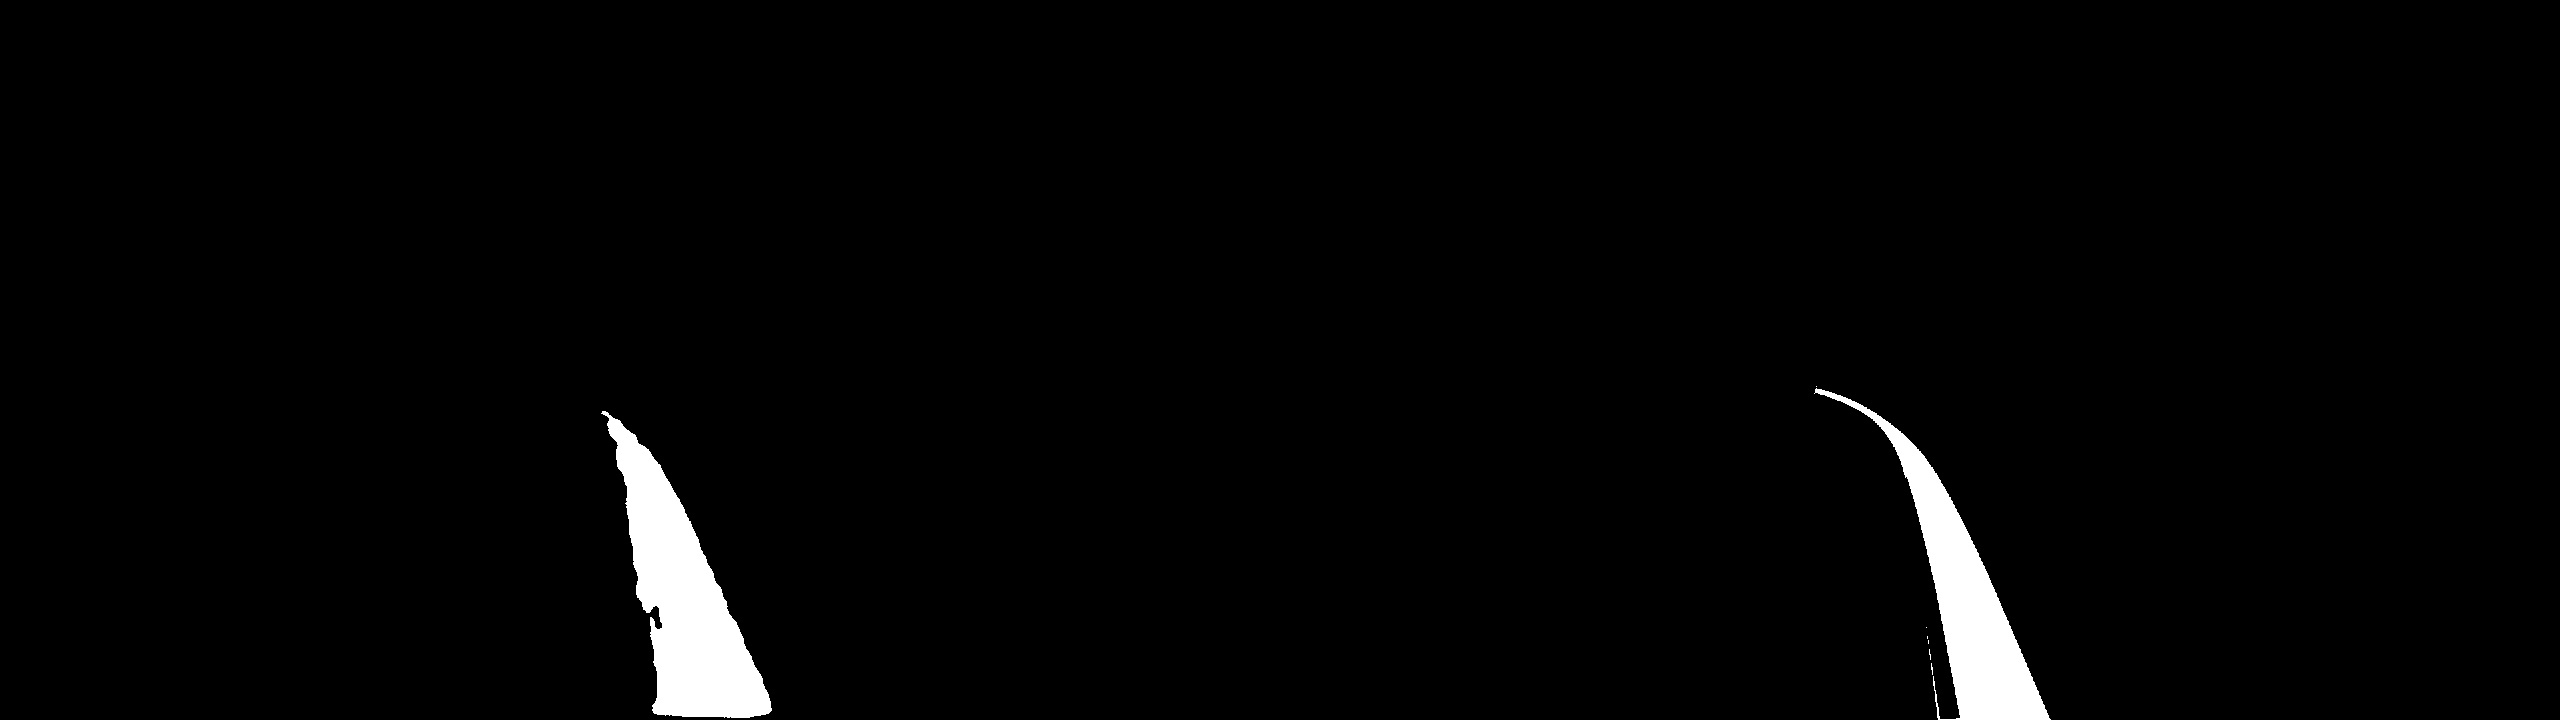

In [ ]:
# idx = 0
# im1 = np.array(results[idx].squeeze()).astype(np.uint8)*255
# Image.fromarray(np.concatenate([im1,masks[idx]*255],axis=-1))

In [ ]:
def update_metrics_seg(preds,
                        gt_mask,
                        task_name=''):
        """Metrics."""
        pred_mask = np.array(preds.squeeze().cpu())

        seg_metrics[task_name].reset()
        seg_metrics[task_name].addBatch(pred_mask, gt_mask)

        seg_result[task_name]['pixacc'].update(seg_metrics[task_name].pixelAccuracy())
        seg_result[task_name]['subacc'].update(seg_metrics[task_name].lineAccuracy())
        seg_result[task_name]['IoU'].update(seg_metrics[task_name].IntersectionOverUnion())
        seg_result[task_name]['mIoU'].update(seg_metrics[task_name].meanIntersectionOverUnion())

In [ ]:
for mask in tqdm(mask_files):
    img = cv2.imread(os.path.join('RailSem19/rs19_jpgs',mask.replace('.png','.jpg')))
    img = cv2.resize(img, (1280, 720))

    im0s = [img]  # yolo batch expects an image inside a list
    im = model.predictor.preprocess(im0s)
    preds = model.predictor.model(im)

    ## model seg predictions
    results = []
    for i, pred in enumerate(preds):
        if isinstance(pred, tuple):
            pass
        else:
            pred = model.predictor.postprocess_seg(pred)
            results.append(pred)

    ## ground truth masks
    masks = []
    path = os.path.join('RailSem19/rs19_masks',mask)
    im_id_map = cv2.imread(path,cv2.IMREAD_GRAYSCALE) #get semantic label map
    for select_classes in class_groups:
        im_id_map_copy = np.copy(im_id_map)
        for select_class in select_classes:
            im_id_map_copy[im_id_map_copy == select_class] = 20 # there are 19 classes so 20 is not used
        im_id_map_copy[im_id_map_copy != 20] = 0
        im_id_map_copy[im_id_map_copy == 20] = 1
        im_id_map_copy = cv2.resize(im_id_map_copy,(1280, 720)) # resize
        # im_id_map_copy = torch.from_numpy(im_id_map_copy) # torch tensor
        masks.append(im_id_map_copy)

    """ Metrics """
    for i,label_name in enumerate(seg_metrics.keys()):
          update_metrics_seg(results[i],
                             masks[i],
                             label_name)

  0%|          | 0/8500 [00:00<?, ?it/s]

In [ ]:
for k in seg_result.keys():
  print(k)
  for k1,v in seg_result[k].items():
    print(k1)
    print(v.avg)
  print()

seg-track-04
pixacc
0.9840119735498357
subacc
0.9376269929583367
IoU
0.7901968597931635
mIoU
0.8865094008397653

seg-rail-05
pixacc
0.9813655514705882
subacc
0.8274080620425115
IoU
0.48533638098376297
mIoU
0.7331340992542957

seg-pole-06
pixacc
0.9811534530739422
subacc
0.7007425581243891
IoU
0.32774667723643824
mIoU
0.6541862933988253



$$$$